In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
# import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Bidirectional
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
import seaborn as sns
import h5py
from tqdm import tqdm

# Loading CSV data


In [ ]:
time_steps = 60

In [ ]:
csv_path = "/Users/jibanchaudhary/Documents/Projects/Trading_bot/merged_dataset.csv"

print("Loading csv data....")

df = pd.read_csv(csv_path)
df.sort_values(['Stock','Date'], inplace=True)
df.reset_index(drop=True, inplace=True)
df[:10]

#Encoding stock identity

In [ ]:
# df['stock_id'] = df['Stock'].astype('category').cat.codes
stock_dummies = pd.get_dummies(df['Stock'], prefix='Stock')
df = pd.concat([df, stock_dummies],axis=1)
numeric_columns = ['Close','% Change','High','Low','Open','Qty.','Turnover']
for col in numeric_columns:
    df[col] = df[col].astype(str).str.replace(',','',regex=False).astype(float)
df

# Technical indicators

In [ ]:
df_list = []
for stock, group in df.groupby('Stock'):
    group = group.copy()
    group.ta.sma(length=20, append=True)
    group.ta.ema(length=50, append=True)
    group.ta.rsi(length=14, append=True)
    group.ta.macd(fast=12, slow=26, signal=9, append=True)
    group.ta.bbands(length=20, append=True)


    if 'SMA_20' not in group.columns or 'EMA_50' not in group.columns:
        continue
    group['Signal'] = 0
    group.loc[group['SMA_20'] > group['EMA_50'], 'Signal'] = 2
    group.loc[group['SMA_20'] < group['EMA_50'], 'Signal'] = 0
    group['Signal'] = np.where((group['Signal'] == 0) & (group['Signal'].shift(1) != 0), 1, group['Signal'])
    group['Signal'] = group['Signal'].replace(to_replace=0, method='ffill')
    group.loc[group['Signal'] == 0, 'Signal'] = 1

    group['Target'] = group['Signal'].shift(-1)
    df_list.append(group)

df = pd.concat(df_list)
df.dropna(inplace=True)
df

In [ ]:
df_list[:10]

In [ ]:
stock_one_hot_cols = [col for col in df.columns if col.startswith('Stock_')]
import json
with open("stock_one_hot_cols.json", "w") as f:
    json.dump(stock_one_hot_cols, f)
feature_cols = ['Close', 'High', 'Low', 'Open'] + stock_one_hot_cols + [
    'SMA_20', 'EMA_50', 'RSI_14',
    'MACD_12_26_9', 'MACDs_12_26_9', 'MACDh_12_26_9',
    'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0']

scaler = MinMaxScaler()
x_all,y_all = [],[]

feature_cols

In [ ]:
len(feature_cols)

# Sliding window for 60 days


In [ ]:
def sliding_data(data, target, time_steps=60):
    num_samples = len(data) - time_steps
    print(f"Length of data : {len(data)}")
    print(f"No of samples : {num_samples}")
    if num_samples < 61:
        return np.array([]),np.array([])

    x= np.zeros((num_samples,time_steps,data.shape[1]),dtype=np.float32)
    y= np.zeros((num_samples,),dtype=np.float32)
    for i in range(num_samples):
        x[i] = data[i:i+time_steps]
        y[i] = target[i+time_steps]
    return x,y

#Debugging only


In [ ]:
# stock_names = sorted(df['Stock'].unique())
# print(stock_names)
group = df[df['Stock']=="CREST"]
print(group)
# print(group.shape)
features = scaler.fit_transform(group[feature_cols])
# features.shape
# print(len(features))

# Creating h5 file list for each stock

In [ ]:
with h5py.File('Stock_dataset.h5','w') as h5f:
    stock_names = sorted(df['Stock'].unique())

    for stock in tqdm(stock_names, desc="Processing stocks"):
        tqdm.write(f"Processing {stock}")
    # for i,(stock,group) in tqdm(enumerate(df.groupby('Stock')),desc=stock):
        group = df[df['Stock']==stock].sort_values('Date')
        # group= group.sort_values('Date')
        group = group.dropna(subset = feature_cols+['Target'])
        features = scaler.fit_transform(group[feature_cols])
        target = group['Target'].values
        x,y = sliding_data(features, target, time_steps)
        if x.size == 0:
            print(f"Sample size less than 60 so SKIPPING.....{stock}")
            continue
        h5f.create_dataset(f"x_{stock}",data=x)
        h5f.create_dataset(f"y_{stock}", data=y)


Loading the H5 file and batchsize

In [ ]:
x_final = np.concatenate(x_all,axis=0)
y_final = np.concatenate(y_all,axis=0)

In [ ]:
idx = np.random.permutation(len(x_final))
x_final,y_final = x_final[idx],y_final[idx]
x_final

In [ ]:
split = int(0.8 * len(x_final))
x_train,x_test = x_final[:split],x_final[split:]
y_train,y_test = y_final[:split],y_final[split:]

# Determining the feature shape dynamically

In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
dataset_path = "/content/drive/MyDrive/Trading/Stock_dataset/Stock_dataset.h5"
batch_size = 256

In [ ]:
# import os
# os.path.getsize(dataset_path)

In [ ]:
with h5py.File(dataset_path,'r') as h5f:
  first_x_key = next(k for k in h5f.keys() if k.startswith('x_'))
  time_steps = h5f[first_x_key].shape[1]
  feature_dim = h5f[first_x_key].shape[2]
  print("Feature shape (time_steps, feature_dim):", time_steps, feature_dim)
# time_steps = 60
# feature_dim = 316



#Data generator

In [ ]:
def data_generator(dataset_path, batchsize):
  h5f = h5py.File(dataset_path,'r')
  x_keys = [k for k in h5f.keys() if k.startswith('x_')]
  while True:
    for key in x_keys:
      stock_name = key.split('_')[1]
      x_data = h5f[key]
      y_data = h5f[f"y_{stock_name}"]
      indices = np.arange(len(x_data))

      for i in range(0,len(x_data),batch_size):
        batch_idx = indices[i:i+batch_size]
        yield x_data[batch_idx], y_data[batch_idx]




#Create tf.data.Dataset with prefetching

In [ ]:
dataset = tf.data.Dataset.from_generator(
    lambda : data_generator(dataset_path, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, time_steps, feature_dim),dtype=tf.float32),
        tf.TensorSpec(shape=(None,),dtype = tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

In [ ]:
steps_per_epoch = 1297 #calculated manually
val_steps = 259
train_dataset = dataset.take(steps_per_epoch).repeat()
val_dataset = dataset.skip(steps_per_epoch).take(val_steps)


#Defining model


In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(
        units=hp.Int('units_1', 32, 128, step=32),
        return_sequences=True,
        input_shape=(time_steps, feature_dim)
    )))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    model.add(Bidirectional(LSTM(units=hp.Int('units_2', 32, 128, step=32))))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    model.add(Dense(25))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# # Step 1: Perform hyperparameter search
# tuner = kt.BayesianOptimization(
#     build_model,
#     objective='val_accuracy',
#     max_trials=3,
#     directory='/content/drive/MyDrive/Trading',
#     project_name='multi_stock_lstm'
# )

# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# tuner.search(
#     train_dataset,
#     validation_data=val_dataset,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=val_steps,
#     epochs=15,
#     callbacks=[stop_early]
# )

Trial 1 Complete [02h 49m 15s]
val_accuracy: 0.9096090793609619

Best val_accuracy So Far: 0.9096090793609619
Total elapsed time: 02h 49m 15s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
32                |96                |units_1
0.4               |0.4               |dropout_1
96                |96                |units_2
0.1               |0.4               |dropout_2
0.001             |0.0001            |learning_rate

Epoch 1/15


In [ ]:
# # Step 1: Perform hyperparameter search
# tuner = kt.BayesianOptimization(
#     build_model,
#     objective='val_accuracy',
#     max_trials=3,
#     directory='multi_stock_tuning',
#     project_name='multi_stock_lstm'
# )

# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# tuner.search(
#     train_dataset,
#     validation_data=val_dataset,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=val_steps,
#     epochs=30,
#     callbacks=[stop_early]
# )

# # Step 2: Retrieve the best hyperparameters
# best_hps = tuner.get_best_hyperparameters(1)[0]

# # Step 3: Build the model using the best hyperparameters
# model = tuner.hypermodel.build(best_hps)

# # Step 4: Train the final model
# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=val_steps,
#     epochs=50,
#     callbacks=[stop_early]
# )

# # # Step 5: Save the trained model
# # model.save("final_multi_stock_lstm_model.h5")
# model.save("final_multi_stock_lstm_model.keras")


In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    directory='/content/drive/MyDrive/Trading',
    project_name='multi_stock_lstm'
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
best_hps = tuner.get_best_hyperparameters(1)[0]

# Step 3: Build the model using the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Step 4: Train the final model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    epochs=30,
    callbacks=[stop_early]
)

# # Step 5: Save the trained model
# model.save("final_multi_stock_lstm_model.h5")
model.save("/content/drive/MyDrive/Trading/Bidirectional-final_multi_stock_lstm_model.keras")

Reloading Tuner from /content/drive/MyDrive/Trading/multi_stock_lstm/tuner0.json
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1297/1297 ━━━━━━━━━━━━━━━━━━━━ 429s 244ms/step - accuracy: 0.7568 - loss: 0.5186 - val_accuracy: 0.8931 - val_loss: 0.2458
Epoch 2/30
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 256s 197ms/step - accuracy: 0.8880 - loss: 0.2661 - val_accuracy: 0.9012 - val_loss: 0.2235
Epoch 3/30
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 217s 168ms/step - accuracy: 0.9012 - loss: 0.2326 - val_accuracy: 0.9057 - val_loss: 0.2132
Epoch 4/30
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 212s 163ms/step - accuracy: 0.9087 - loss: 0.2142 - val_accuracy: 0.9110 - val_loss: 0.2018
Epoch 5/30
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 218s 168ms/step - accuracy: 0.9148 - loss: 0.1999 - val_accuracy: 0.9136 - val_loss: 0.1952
Epoch 6/30
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 252s 194ms/step - accuracy: 0.9177 - loss: 0.1906 - val_accuracy: 0.9165 - val_loss: 0.1892
Epoch 7/30
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 203s 156ms/step - accuracy: 0.9218 - loss: 0.1825 - val_accuracy: 0.9169 - val_loss: 0.1900
Epoch 8/30
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 206s 159ms/step - accuracy: 0.9

# # Step 5: Save the trained model

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [ ]:
model.save("final_multi_stock_lstm_model.keras")

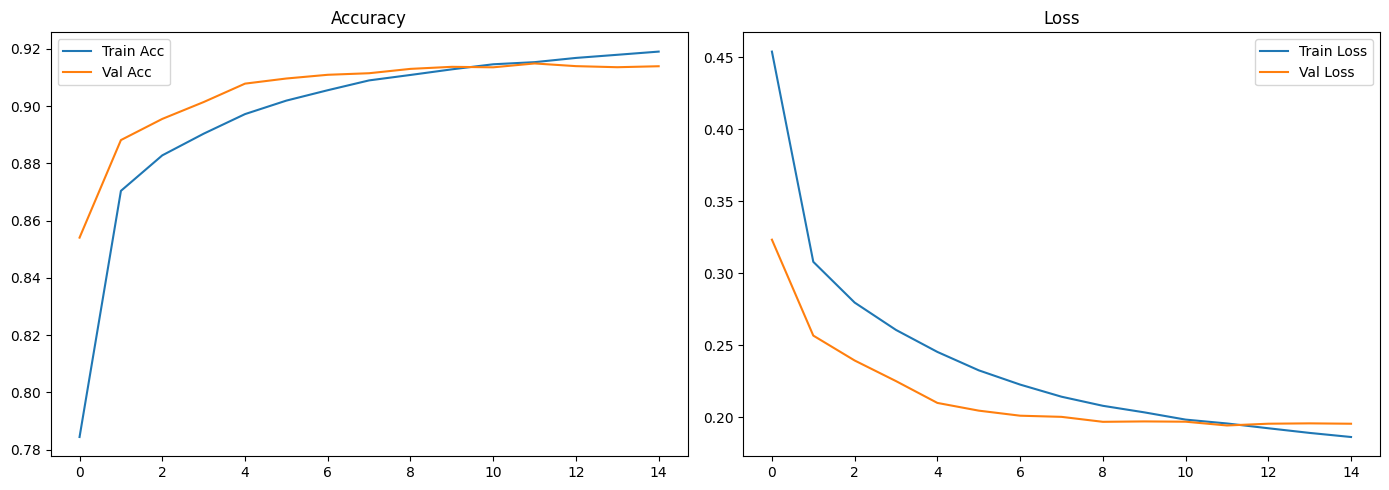

In [ ]:
# ---------------------- 8. Training Curve ----------------------
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.tight_layout()
plt.show()


#Testing

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Sell (0)', 'Buy (2)']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


NameError: name 'x_test' is not defined